## **Introduction**

The **Reuters-21578 dataset** is a collection of 21,578 financial news articles, curated to support tasks in natural language processing (NLP) and machine learning, particularly text classification. Each article is tagged with one or more topics, enabling a variety of descriptive and predictive analyses.

This notebook focuses on the **descriptive analysis** of the dataset, aiming to uncover key patterns and characteristics of the data. The goal is to prepare and analyze the dataset for the subsequent task of developing a classification model.

### **Dataset Overview:**
- **Source**: The dataset consists of financial articles sourced from Reuters.
- **Topics**: Although the dataset includes 135 topics, this exercise narrows the focus to **5 key topics**:
  1. Money/Foreign Exchange (**MONEY-FX**)
  2. Shipping (**SHIP**)
  3. Interest Rates (**INTEREST**)
  4. Mergers/Acquisitions (**ACQ**)
  5. Earnings and Earnings Forecasts (**EARN**)
- **Format**: The dataset is distributed across 22 `.sgm` files, with each file containing articles and associated metadata.

### **Objectives:**
1. **Descriptive Analysis**:
   - Explore the main characteristics of each topic.
   - Identify key trends, such as the frequency of topics or the distribution of attributes like `Dateline`, `Title`, and `Body`.
2. **Data Preparation**:
   - Clean and preprocess the data for future modeling.
   - Handle missing values, duplicates, and inconsistencies.


### **Outcome:**
By the end of this notebook, the dataset will be thoroughly explored and preprocessed, setting a solid foundation for the next phase: building a predictive model to classify articles into their respective topics.


## **Setup**

In [ ]:
from google.colab import drive
import os
from typing import List, Dict
from collections import Counter
from itertools import chain
import tarfile
from bs4 import BeautifulSoup
import pandas as pd
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import nltk
from nltk.util import ngrams

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## **Data Loading and Initial Inspection:**

This section handles loading and extracting the dataset from the sgm files and some initial inspection of the data.

We start by extracting the Reuters-21578 dataset.


In [ ]:
drive.mount('/content/drive', force_remount=True)

file_path = '/content/drive/My Drive/reuters21578.tar.gz'

extract_path = '/content/extracted_files'

os.makedirs(extract_path, exist_ok=True)

# Extract the files
if os.path.exists(file_path):
    with tarfile.open(file_path, 'r:gz') as tar_ref:
        tar_ref.extractall(extract_path)
    print(f"Files extracted to {extract_path}")
else:
    print(f"File not found: {file_path}. Check if the path is correct.")


Mounted at /content/drive
Files extracted to /content/extracted_files


To understand the structure of the dataset, we define a function to read .sgm files and print the content of a document (reut2-000.sgm) for initial inspection.

In [ ]:
def read_sgm_file(file_path):
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            content = file.read()
            return content
    except Exception as e:
        return f"An error occurred: {e}"

file_path = "/content/extracted_files/reut2-000.sgm"

sgm_content = read_sgm_file(file_path)
print(sgm_content)


<!DOCTYPE lewis SYSTEM "lewis.dtd">
<REUTERS TOPICS="YES" LEWISSPLIT="TRAIN" CGISPLIT="TRAINING-SET" OLDID="5544" NEWID="1">
<DATE>26-FEB-1987 15:01:01.79</DATE>
<TOPICS><D>cocoa</D></TOPICS>
<PLACES><D>el-salvador</D><D>usa</D><D>uruguay</D></PLACES>
<PEOPLE></PEOPLE>
<ORGS></ORGS>
<EXCHANGES></EXCHANGES>
<COMPANIES></COMPANIES>
<UNKNOWN> 
&#5;&#5;&#5;C T
&#22;&#22;&#1;f0704&#31;reute
u f BC-BAHIA-COCOA-REVIEW   02-26 0105</UNKNOWN>
<TEXT>&#2;
<TITLE>BAHIA COCOA REVIEW</TITLE>
<DATELINE>    SALVADOR, Feb 26 - </DATELINE><BODY>Showers continued throughout the week in
the Bahia cocoa zone, alleviating the drought since early
January and improving prospects for the coming temporao,
although normal humidity levels have not been restored,
Comissaria Smith said in its weekly review.
    The dry period means the temporao will be late this year.
    Arrivals for the week ended February 22 were 155,221 bags
of 60 kilos making a cumulative total for the season of 5.93
mln against 5.81 at the sa

We will now parse all the documents to extract relevant information,, and organize it into a structured DataFrame.

In [ ]:
# Function to extract the data
def extract_data(file_path):
    with open(file_path, 'r', encoding='latin-1') as file:
        content = file.read()

    # Parse the content
    soup = BeautifulSoup(content, 'html.parser')

    # List to store parsed data
    data = []

    # Iterate over each <REUTERS> tag
    for article in soup.find_all('reuters'):
        # Extract attributes
        topics = ', '.join([d.get_text() for d in article.find('topics').find_all('d')]) if article.find('topics') else None
        places = ', '.join([d.get_text() for d in article.find('places').find_all('d')]) if article.find('places') else None
        people = ', '.join([d.get_text() for d in article.find('people').find_all('d')]) if article.find('people') else None
        orgs = ', '.join([d.get_text() for d in article.find('orgs').find_all('d')]) if article.find('orgs') else None
        exchanges = ', '.join([d.get_text() for d in article.find('exchanges').find_all('d')]) if article.find('exchanges') else None
        companies = ', '.join([d.get_text() for d in article.find('companies').find_all('d')]) if article.find('companies') else None

        lewissplit = article.get('lewissplit')
        cgisplit = article.get('cgisplit')
        oldid = article.get('oldid')
        newid = article.get('newid')
        text_tag = article.find('text')
        if text_tag:
            title = text_tag.find('title').get_text() if text_tag.find('title') else None
            dateline = text_tag.find('dateline').get_text() if text_tag.find('dateline') else None
            body = text_tag.find('body').get_text() if text_tag.find('body') else None
        else:
            title = None
            dateline = None
            body = None

        # Append data to the list
        data.append({
            'Topics': topics,
            'Places': places,
            'People': people,
            'Orgs': orgs,
            'Exchanges': exchanges,
            'Companies': companies,
            'LEWISSPLIT': lewissplit,
            'CGISPLIT': cgisplit,
            'OLDID': oldid,
            'NEWID': newid,
            'Title': title,
            'Dateline': dateline,
            'Body': body,
        })

    # Convert the list to a DataFrame
    df = pd.DataFrame(data)
    return df

sgm_directory = '/content/extracted_files'

all_dataframes = []

# Loop through each file in the directory
for file_name in os.listdir(sgm_directory):
    if file_name.endswith('.sgm'):
        file_path = os.path.join(sgm_directory, file_name)
        # Parse the file and append the dataframe to the list
        df = extract_data(file_path)
        all_dataframes.append(df)

# Combine all dataframes into a single dataframe
df = pd.concat(all_dataframes, ignore_index=True)

In [ ]:
df

,Topics,Places,People,Orgs,Exchanges,Companies,LEWISSPLIT,CGISPLIT,OLDID,NEWID,Title,Dateline,Body
0,earn,uk,,,,,TRAIN,TRAINING-SET,18419,2001,JAGUAR SEES STRONG GROWTH IN NEW MODEL SALES,"LONDON, March 5 -",Jaguar Plc <JAGR.L> is about to sell its\nnew ...
1,,,,,,,TRAIN,TRAINING-SET,18420,2002,OCCIDENTAL PETROLEUM COMMON STOCK OFFERING RAI...,None,None
2,"grain, wheat","usa, iraq",,,,,TRAIN,TRAINING-SET,18421,2003,CCC ACCEPTS BONUS BID ON WHEAT FLOUR TO IRAQ,"WASHINGTON, March 5 -","The Commodity Credit Corporation,\nCCC, has ac..."
3,crude,,,,,,TRAIN,TRAINING-SET,18422,2004,DIAMOND SHAMROCK RAISES CRUDE POSTED PRICES ON...,None,None
4,earn,usa,,,,,TRAIN,TRAINING-SET,18423,2005,NORD RESOURCES CORP <NRD> 4TH QTR NET,"DAYTON, Ohio, March 5 -\n","Shr 19 cts vs 13 cts\n Net 2,656,000 vs 1,7..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21573,acq,usa,icahn,,,,TRAIN,TRAINING-SET,18414,1996,USAIR <U> REJECTS TWA <TWA> TAKEOVER BID,"WASHINGTON, March 5 -",USAir Group Inc said its board has\nrejected T...
21574,,usa,,,,,TRAIN,TRAINING-SET,18415,1997,PAYLESS CASHWAYS INC <PCI> FEBRUARY SALES RISE,"KANSAS CITY, MO., March 5 -",Payless Cashways Inc said its\nsales for the f...
21575,,canada,,,,,TRAIN,TRAINING-SET,18416,1998,STERIVET <STVTF> TO DEVELOP NEW HORSE DRUG,"TORONTO, March 5 -",Sterivet Laboratories Ltd said it is\nproceedi...
21576,,usa,,,,,TRAIN,TRAINING-SET,18417,1999,U.S. EXPANSION THREATENED - CONGRESSIONAL REPORT,"WASHINGTON, March 5 -",The U.S. economy is facing several\nserious pr...


In [ ]:
print("Colonnes de la dataframe et leurs types :\n")
for col in df.columns:
    print(f"- {col} ({df[col].dtype})")

Colonnes de la dataframe et leurs types :

- Topics (object)
- Places (object)
- People (object)
- Orgs (object)
- Exchanges (object)
- Companies (object)
- LEWISSPLIT (object)
- CGISPLIT (object)
- OLDID (object)
- NEWID (object)
- Title (object)
- Dateline (object)
- Body (object)


In [ ]:
print(f"Dataset shape: {df.shape}")

Dataset shape: (21578, 13)


In [ ]:
print(f"Column names:\n{df.columns}")

Column names:
Index(['Topics', 'Places', 'People', 'Orgs', 'Exchanges', 'Companies',
       'LEWISSPLIT', 'CGISPLIT', 'OLDID', 'NEWID', 'Title', 'Dateline',
       'Body'],
      dtype='object')


In [ ]:
print(f"Missing values per column:{df.isnull().sum()}")

Missing values per column:Topics           0
Places           0
People           0
Orgs             0
Exchanges        0
Companies        0
LEWISSPLIT       0
CGISPLIT         0
OLDID            0
NEWID            0
Title          737
Dateline      2535
Body          2535
dtype: int64


In [ ]:
print(f"Dataset info:")
print(df.info())

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21578 entries, 0 to 21577
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Topics      21578 non-null  object
 1   Places      21578 non-null  object
 2   People      21578 non-null  object
 3   Orgs        21578 non-null  object
 4   Exchanges   21578 non-null  object
 5   Companies   21578 non-null  object
 6   LEWISSPLIT  21578 non-null  object
 7   CGISPLIT    21578 non-null  object
 8   OLDID       21578 non-null  object
 9   NEWID       21578 non-null  object
 10  Title       20841 non-null  object
 11  Dateline    19043 non-null  object
 12  Body        19043 non-null  object
dtypes: object(13)
memory usage: 2.1+ MB
None


In [ ]:
print("\nSummary statistics:")
print(df.describe())


Summary statistics:
       Topics Places People   Orgs Exchanges Companies LEWISSPLIT  \
count   21578  21578  21578  21578     21578     21578      21578   
unique    656   1097    218     68        58         1          3   
top              usa                                        TRAIN   
freq    10211  10878  20422  20697     21096     21578      14668   

            CGISPLIT  OLDID  NEWID                                  Title  \
count          21578  21578  21578                                  20841   
unique             2  21578  21578                                  20029   
top     TRAINING-SET  18419   2001  HOG AND CATTLE SLAUGHTER GUESSTIMATES   
freq           20856      1      1                                     25   

                          Dateline  \
count                        19043   
unique                        8822   
top         WASHINGTON, April 9 -    
freq                           111   

                                                     Bod

In [ ]:
print(f"List of Topics: \n{df['Topics'].unique()}")

List of Topics: 
['earn' '' 'grain, wheat' 'crude' 'copper' 'crude, nat-gas' 'acq' 'ship'
 'money-fx, interest' 'money-fx' 'grain, wheat, barley, corn'
 'earn, crude' 'interest' 'gold' 'grain, wheat, copper' 'oilseed, soybean'
 'reserves' 'coffee' 'livestock' 'grain, barley'
 'grain, barley, wheat, corn, oilseed, rapeseed' 'money-fx, yen'
 'money-fx, dlr' 'grain, corn' 'copper, lead, zinc, strategic-metal'
 'crude, ship' 'money-fx, dlr, yen' 'grain, wheat, barley' 'acq, earn'
 'sugar, acq' 'gnp, jobs' 'sugar' 'livestock, hog, carcass' 'retail'
 'gnp, trade' 'trade' 'trade, money-fx'
 'trade, sugar, cotton, groundnut, oilseed' 'pet-chem'
 'grain, wheat, corn, soybean, oilseed'
 'livestock, l-cattle, carcass, sugar' 'orange' 'nat-gas' 'money-supply'
 'money-fx, can' 'veg-oil, groundnut' 'livestock, carcass'
 'grain, corn, oilseed, soybean, veg-oil, soy-oil, meal-feed, soy-meal, cotton'
 'trade, crude, nat-gas' 'coffee, oilseed, soybean, trade, sugar, cocoa'
 'cpi' 'trade, grain, wheat' '

## **Data Cleaning:**

Since the exercise focuses on five specific topics:
-	Money/Foreign Exchange (MONEY-FX)
-	Shipping (SHIP)
-	Interest Rates (INTEREST)
-	Mergers/Acquisitions (ACQ)
-	Earnings and Earnings Forecasts (EARN)

we filter the dataset to include only articles related to these topics.

In [ ]:
values = ['money-fx', 'earn', "ship", "interest", "acq"]
new_df = df[df['Topics'].isin(values)].reset_index(drop=True)

In [ ]:
missing_Title_count = new_df['Title'].isna().sum()
total_rows = len(new_df)
missing_Title_proportion = missing_Title_count / total_rows

print(f"Total rows: {total_rows}")
print(f"Missing 'Title' count: {missing_Title_count}")
print(f"Proportion of missing 'Title': {missing_Title_proportion:.2%}")

Total rows: 7057
Missing 'Title' count: 30
Proportion of missing 'Title': 0.43%


*   The analysis reveals that only 0.43% of the rows (30 out of 7057) are missing the Title column.
*   Since the proportion of missing titles is minimal, these rows are unlikely to significantly impact the dataset's integrity.

In [ ]:
missing_title_body_count = new_df[new_df['Title'].isna() & new_df['Body'].isna()].shape[0]

print(f"Number of rows with neither 'Title' nor 'Body': {missing_title_body_count}")


Number of rows with neither 'Title' nor 'Body': 30



*   All rows with missing Title also have missing Body (30 rows in total).
*   This confirms that these rows lack meaningful textual content and could be dropped if necessary for downstream analysis.

In [ ]:
missing_body_count = new_df['Body'].isna().sum()
total_rows = len(new_df)
missing_body_proportion = missing_body_count / total_rows

print(f"Total rows: {total_rows}")
print(f"Missing 'Body' count: {missing_body_count}")
print(f"Proportion of missing 'Body': {missing_body_proportion:.2%}")
print(f"Total of data after droping missing 'Body': {total_rows - missing_body_count}")

Total rows: 7057
Missing 'Body' count: 571
Proportion of missing 'Body': 8.09%
Total of data after droping missing 'Body': 6486


*   About 8.09% of rows (571 out of 7057) are missing the Body column.
*   Even with missing bodies, many of these rows still have a Title, which may provide useful information.
*   After dropping rows with missing Body, 6486 rows would remain, representing a slight reduction in data size.

*   To retain as much information as possible, a new Text column is created by combining Title and Body.
*   Missing Body values are replaced with an empty string, ensuring no information is lost from rows that have a valid Title.

In [ ]:
new_df['Text'] = new_df['Title'] + ' ' + new_df['Body'].fillna('')

In [ ]:
columns_info = pd.DataFrame({
    "Nom de la colonne": new_df.columns,
    "Type de données": [new_df[col].dtype for col in new_df.columns]
})

print(columns_info)

   Nom de la colonne Type de données
0             Topics          object
1             Places          object
2             People          object
3               Orgs          object
4          Exchanges          object
5          Companies          object
6         LEWISSPLIT          object
7           CGISPLIT          object
8              OLDID          object
9              NEWID          object
10             Title          object
11          Dateline          object
12              Body          object
13              Text          object


We narrow the dataset to include only the necessary columns for analysis:

1.   LEWISSPLIT: Identifies the data split (e.g., training or testing).
2.   Text: The combined content of Title and Body, serving as the input for analysis.
3.    Topics: The target labels for classification.

This step focuses on the most relevant data attributes to align with the exercise objectives.

In [ ]:
new_df = new_df[['LEWISSPLIT', 'Text', 'Topics']]

new_df

,LEWISSPLIT,Text,Topics
0,TRAIN,JAGUAR SEES STRONG GROWTH IN NEW MODEL SALES J...,earn
1,TRAIN,NORD RESOURCES CORP <NRD> 4TH QTR NET Shr 19 c...,earn
2,TRAIN,FIVE GROUPS APPLY TO BUY FRENCH TELEPHONE GROU...,acq
3,TRAIN,BLIZZARD CLOSES BOSPHORUS Blizzard conditions ...,ship
4,TRAIN,JAPAN FUND <JPN> SEEKERS CONFIDENT OF FINANCIN...,acq
...,...,...,...
7052,TRAIN,BAKER INTERNATIONAL CORP SUES HUGHES TOOL SEEK...,acq
7053,TRAIN,USAIR GROUP REJECTS TRANS WORLD AIRLINES TAKEO...,acq
7054,TRAIN,BAKER <BKO> SUES TO FORCE HUGHES <HT> MERGER B...,acq
7055,TRAIN,SPAIN DEREGULATES BANK DEPOSIT INTEREST RATES ...,interest


In [ ]:
new_df['Topics'].value_counts()

,count
Topics,
earn,3945
acq,2362
money-fx,307
interest,285
ship,158


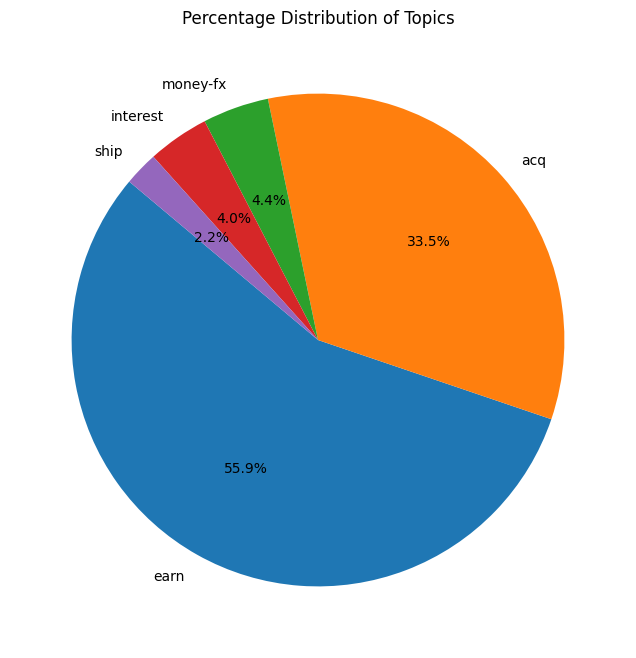

In [ ]:
topic_counts = new_df['Topics'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(
    topic_counts,
    labels=topic_counts.index,
    autopct='%1.1f%%',
    startangle=140,
)
plt.title('Percentage Distribution of Topics')
plt.show()

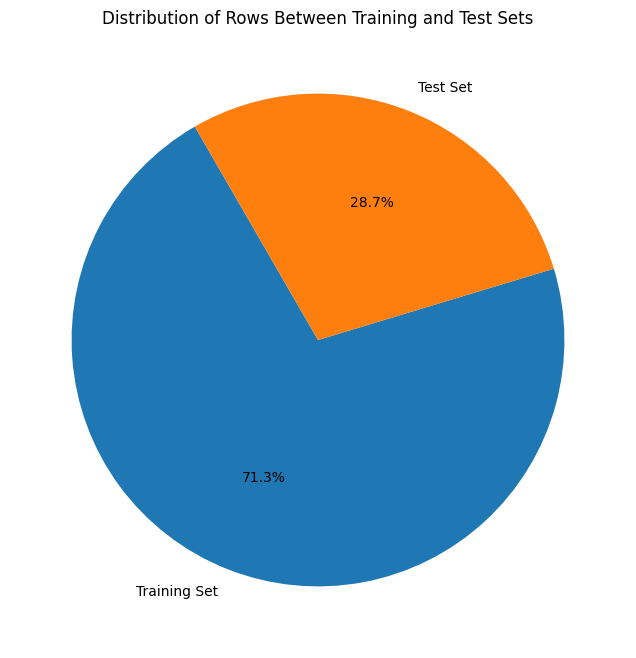

In [ ]:
train_count = new_df[new_df['LEWISSPLIT'] == 'TRAIN'].shape[0]
test_count = new_df[new_df['LEWISSPLIT'] == 'TEST'].shape[0]

labels = ['Training Set', 'Test Set']
sizes = [train_count, test_count]

plt.figure(figsize=(8, 8))
plt.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    startangle=120,
)
plt.title('Distribution of Rows Between Training and Test Sets')
plt.show()


## **Descriptive Statistics:**

First, we compute basic statistics about the dataset to understand its overall structure. This includes the number of text samples, the average length of the text, and the vocabulary size. These metrics provide an initial sense of the dataset's scale, complexity, and diversity, helping to guide subsequent preprocessing and analysis steps.

In [ ]:
def basic_statistics(Text : pd.Series) -> Dict[str, float]:
    """
    Calculate basic statistics about the text data in the DataFrame.

    Args:
        text_column (pd.Series): The text column in the DataFrame.

    Returns:
        Dict[str, float]: A dictionary containing the basic statistics.
    """
    Text = Text.dropna().astype(str)
    # Count the number of samples
    num_samples = len(Text)

    # Calculate the average length of the text
    total_length = sum(len(Text) for text in Text)
    avg_length = total_length / num_samples if num_samples > 0 else 0

    # claculate the vocabulary size
    all_words = ' '.join(Text).split()
    vocab_size = len(set(all_words))

    return {
        'Number of Samples': num_samples,
        'Average Text Length': avg_length,
        'Vocabulary Size': vocab_size
    }

basic_stats = basic_statistics(new_df['Text'])
basic_stats

{'Number of Samples': 7027,
 'Average Text Length': 7027.0,
 'Vocabulary Size': 57227}

Next, we analyze the frequency of words in the dataset to identify the most and least common terms. This step helps uncover patterns in word usage, highlights important terms, and provides insights into the dataset's vocabulary.

In [ ]:
def word_frequency_analysis(Text : pd.Series, n_most_frequent: int = 10, n_least_frequent: int = 10) -> Dict[str, List[str]]:
    """
    Analyze the frequency of words in the text column.

    Args:
        text_column (pd.Series): The text column in the DataFrame.
        n_most_frequent (int): Number of most frequent words to return.
        n_least_frequent (int): Number of least frequent words to return.

    Returns:
        Dict[str, List[str]]: A dictionary containing lists of most and least frequent words.
    """
    Text = Text.dropna().astype(str)
    # Splitting text and lowering it
    all_words = ' '.join(Text).lower().split()
    word_freq = Counter(all_words)

    # the n most frequent words
    most_frequent_words = word_freq.most_common(n_most_frequent)

    # the n least frequent words
    least_frequent_words = word_freq.most_common()[:-n_least_frequent-1:-1]

    return {
        'Most Frequent Words': most_frequent_words,
        'Least Frequent Words': least_frequent_words,
    }

word_freq_stats = word_frequency_analysis(new_df['Text'])
word_freq_stats

{'Most Frequent Words': [('the', 28195),
  ('of', 18323),
  ('to', 15212),
  ('vs', 14130),
  ('mln', 13540),
  ('in', 12023),
  ('a', 11791),
  ('and', 11755),
  ('said', 9497),
  ('cts', 7853)],
 'Least Frequent Words': [('inapplicable', 1),
  ('render', 1),
  ('eleventh', 1),
  ('icahn-led', 1),
  ('passengers.', 1),
  ('liberalisation.', 1),
  ('dehesa', 1),
  ('guillermo', 1),
  ('interest."', 1),
  ('enacted', 1)]}

The word frequency analysis reveals the following insights about the dataset:

**Most Frequent Words**

The 10 most common words are:
- **High-frequency function words**: Words like `the`, `of`, `to`, `in`, `and` are common across texts, representing stopwords.The high frequency of stopwords suggests they should be removed to better focus on domain-specific terms.
- **Domain-specific terms**: Words like `vs`, `mln`, and `cts` suggest the financial context of the dataset.

**Least Frequent Words**

The 10 least common words appear only once and include:
- **Niche terms**: Words like `fibres.`, `silk`, and `messel` likely come from specific articles.


In [ ]:
def most_frequent_words_with_stopwords_removal(Text: pd.Series, n_most_frequent: int = 10, n_least_frequent: int = 10) -> Dict[str, List[str]]:
    """
    Analyze the frequency of words in the text column after lowercasing and removing stopwords.

    Args:
        Text (pd.Series): The text column in the DataFrame.
        n_most_frequent (int): Number of most frequent words to return.
        n_least_frequent (int): Number of least frequent words to return.

    Returns:
        Dict[str, List[str]]: A dictionary containing lists of most and least frequent words.
    """
    Text = Text.dropna().astype(str)
    # list of stopwords

    stop_words = set(stopwords.words('english'))

    # Splitting the text lowecasing it and removing stopwords
    all_words = ' '.join(Text).lower().split()
    filtered_words = [word for word in all_words if word not in stop_words]

    # Count word frequencies
    word_freq = Counter(filtered_words)

    # the n most frequent words
    most_frequent_words = word_freq.most_common(n_most_frequent)

    return most_frequent_words

most_frequent_words_without_stopwords = most_frequent_words_with_stopwords_removal(new_df['Text'])
print("The most frequent words in the dataset (without stopwords):")
most_frequent_words_without_stopwords


The most frequent words in the dataset (without stopwords):


[('vs', 14130),
 ('mln', 13540),
 ('said', 9497),
 ('cts', 7853),
 ('net', 6766),
 ('dlrs', 6714),
 ('\x03', 6486),
 ('reuter', 6437),
 ('loss', 4940),
 ('shr', 4036)]

**N-gram Analysis**

To gain deeper insights into common phrases and word combinations in the dataset, we perform an n-gram analysis.

The ngram_analysis function calculates the frequency of n-grams (continuous sequences of n words) within the text data. It allows us to specify the size of n (e.g., 2 for bi-grams, 3 for tri-grams) and the number of top frequent n-grams to retrieve.


In [ ]:
def ngram_analysis(Text : pd.Series, n: int, top_n: int = 10) -> List[str]:
    """
    Analyze the frequency of n-grams in the text column, excluding specific unwanted characters.

    Args:
        text_column (pd.Series): The text column in the DataFrame.
        n (int): The size of the n-gram (bi-gram: 2, tri-gram: 3, etc.)
        top_n (int): Number of most frequent n-grams to return.

    Returns:
        List[str]: A list of the most frequent n-grams.
    """
    Text = Text.dropna().astype(str)
    # Splitting the text lowecasing it
    all_words = ' '.join(Text).lower().split()

    # Generate n-grams
    n_grams = ngrams(all_words, n)

    # Removing ngrams that have end of text
    filtered_ngrams = [ng for ng in n_grams if '\x03' not in ng]

    # Count the frequency of each filtered n-gram
    ngram_freq = Counter(filtered_ngrams)

    # the top_n most frequent n-grams
    most_frequent_ngrams = ngram_freq.most_common(top_n)

    return most_frequent_ngrams

bigram_stats = ngram_analysis(new_df['Text'], 2)
trigram_stats = ngram_analysis(new_df['Text'], 3)


In [ ]:
print(f"the most frequent bi-grams in the dataset:")
bigram_stats

the most frequent bi-grams in the dataset:


[(('mln', 'vs'), 3947),
 (('said', 'it'), 3290),
 (('cts', 'vs'), 3285),
 (('of', 'the'), 3204),
 (('in', 'the'), 2634),
 (('cts', 'net'), 2220),
 (('mln', 'dlrs'), 2108),
 (('the', 'company'), 1978),
 (('said', 'the'), 1809),
 (('vs', 'loss'), 1775)]

In [ ]:
print(f"the most frequent tri-grams in the dataset:")
trigram_stats

the most frequent tri-grams in the dataset:


[(('the', 'company', 'said'), 742),
 (('cts', 'vs', 'loss'), 659),
 (('mln', 'avg', 'shrs'), 621),
 (('qtr', 'net', 'shr'), 577),
 (('said', 'it', 'has'), 577),
 (('cts', 'net', 'loss'), 521),
 (('inc', 'said', 'it'), 501),
 (('mln', 'dlrs', 'in'), 496),
 (('pct', 'of', 'the'), 434),
 (('nine', 'mths', 'shr'), 414)]

In [ ]:
# Save dataset to a CSV file
new_df.to_csv('/content/drive/MyDrive/topics_classification_dataset.csv', index=False)
